In [345]:
# resetting the entire session
%reset -f  
# Iris data-set
from sklearn.datasets import load_iris

# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

In [346]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape

((120, 4), (120,))

### Quantum Machine Learning Model
we’ll train a variational quantum classifier (VQC), available in Qiskit Machine Learning 
 Two of its central elements are the feature map and ansatz.

In [347]:
# features circuit
from qiskit.circuit.library import ZZFeatureMap
num_features = X.shape[1]
feature_circ = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_circ.decompose().draw(output='text', fold=-1)

┌───┐┌─────────────┐                                                                                                                                                                                                                            
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■────■────────────────────────────────────■─────────■─────────────────────────────────────────■──────────────────────────────────────────────────────────────────────────────────────
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐  │                                    │         │                                         │                                                                                      
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──┼────────────────────────────────────┼────■────┼────────────────────────────────────■────┼────■────────────────────────────────────■────────────────────────────────────────────
     ├───┤├─────────────┤└───┘└──────────────────────────────┘└───┘┌─┴─┐┌──────────────────────────────┐┌─┴─┐┌─┴─┐  │  ┌──────────────────────────────┐┌─┴─┐  │    │                                    │                                            
q_2: ┤ H ├┤ P(2.0*x[2]) ├──────────────────────────────────────────┤ X ├┤ P(2.0*(π - x[0])*(π - x[2])) ├┤ X ├┤ X ├──┼──┤ P(2.0*(π - x[1])*(π - x[2])) ├┤ X ├──┼────┼────────────────────────────────────┼────■────────────────────────────────────■──
     ├───┤├─────────────┤                                          └───┘└──────────────────────────────┘└───┘└───┘┌─┴─┐├──────────────────────────────┤└───┘┌─┴─┐┌─┴─┐┌──────────────────────────────┐┌─┴─┐┌─┴─┐┌──────────────────────────────┐┌─┴─┐
q_3: ┤ H ├┤ P(2.0*x[3]) ├─────────────────────────────────────────────────────────────────────────────────────────┤ X ├┤ P(2.0*(π - x[0])*(π - x[3])) ├─────┤ X ├┤ X ├┤ P(2.0*(π - x[1])*(π - x[3])) ├┤ X ├┤ X ├┤ P(2.0*(π - x[2])*(π - x[3])) ├┤ X ├
     └───┘└─────────────┘                                                                                         └───┘└──────────────────────────────┘     └───┘└───┘└──────────────────────────────┘└───┘└───┘└──────────────────────────────┘└───┘

In [348]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import ParameterVector

def rotation_block(circuit, parameters):
    # assumes nb of params equal to num of qubits
    for i in range(circuit.num_qubits):
        circuit.ry(parameters[i],i)

def non_linear(circuit, param, qubit):
    # the circuit, the parameter and the qubit of interest
    circuit.ry(param, qubit)
    circuit.measure(qubit, 0)
    circuit.ry(-param, qubit)

def myAnsatz(nFeat, reps, midMeasLL, barrier=True, final_rotation=True):
    #... compute range of paramaters index per repetition
    # midMeasLL is list of list, different qubits can be measured in each repetition
    assert len(midMeasLL)==reps
    n1=0 
    nParL=[]
    for midmL in midMeasLL:
        n0=n1
        n1=n0+nFeat+len(midmL)
        nParL.append(n0)
    if final_rotation: 
        n0=n1
        n1=n0+nFeat
        nParL.append(n0)
    totPar=n1
    print('nParL:',nParL,totPar)
   
    beta = ParameterVector('beta', length=totPar)
    qubits = QuantumRegister(nFeat,'q')
    meas = ClassicalRegister(nFeat,'c')
    qc = QuantumCircuit(qubits, meas)

    for ir in range(reps):
        n0=nParL[ir]
        rotation_block(qc, beta[n0:n0+nFeat])
        if barrier: qc.barrier()
        
        #entanglement block, here linear but can easily be changed depending on what you want ...
        
        qc.cx(range(nFeat-2,-1,-1), range(nFeat-1,0,-1))
        if qc: qc.barrier()
    
        # non-linear part
        qL=midMeasLL[ir]
        n0+=nFeat
        print('icyc:%d qL:%s'%(ir,str(qL))
        for j, qid in enumerate(qL):
            non_linear(qc, beta[n0+j],qid)
        if barrier: qc.barrier()
        
    #final rotation block, optional
    if final_rotation: 
        n0=nParL[-1]
        rotation_block(qc, beta[n0:n0+nFeat])
        
    if barrier: qc.barrier()
    qc.measure(range(nFeat),meas)
    return qc, qubits, meas

In [349]:
# Anzatz circuit
nReps=4
midMeasLL=[ [] for i in range(nReps) ] # no midMeas at all
midMeasLL=[[2,3],[]]  # select midMeas qubits per repetition
midMeasLL=[[],[2],[0],[1]]  # select midMeas qubits per repetition
ansatz_circ = myAnsatz(num_features, reps=nReps, midMeasLL=midMeasLL, barrier=True, final_rotation=True)[0]
ansatz_circ.decompose().draw(output='text', fold=-1)

nParL: [0, 4, 9, 14, 19] 23
ir; 0 []
ir; 1 [2]
ir; 2 [0]
ir; 3 [1]


┌────────────────┐ ░                 ░  ░ ┌────────────────┐ ░                 ░                                              ░  ┌────────────────┐ ░                 ░ ┌─────────────────┐┌─┐┌──────────────────────┐ ░ ┌─────────────────┐ ░                 ░                                                ░ ┌─────────────────┐ ░ ┌─┐         
q_0: ┤ R(beta[0],π/2) ├─░─────────────■───░──░─┤ R(beta[4],π/2) ├─░─────────────■───░──────────────────────────────────────────────░──┤ R(beta[9],π/2) ├─░─────────────■───░─┤ R(beta[13],π/2) ├┤M├┤ R(-1.0*beta[13],π/2) ├─░─┤ R(beta[14],π/2) ├─░─────────────■───░────────────────────────────────────────────────░─┤ R(beta[19],π/2) ├─░─┤M├─────────
     ├────────────────┤ ░           ┌─┴─┐ ░  ░ ├────────────────┤ ░           ┌─┴─┐ ░                                              ░ ┌┴────────────────┤ ░           ┌─┴─┐ ░ └─────────────────┘└╥┘└──────────────────────┘ ░ ├─────────────────┤ ░           ┌─┴─┐ ░ ┌─────────────────┐┌─┐┌──────────────────────┐ ░ ├─────────────────┤ ░ └╥┘┌─┐      
q_1: ┤ R(beta[1],π/2) ├─░────────■──┤ X ├─░──░─┤ R(beta[5],π/2) ├─░────────■──┤ X ├─░──────────────────────────────────────────────░─┤ R(beta[10],π/2) ├─░────────■──┤ X ├─░─────────────────────╫──────────────────────────░─┤ R(beta[15],π/2) ├─░────────■──┤ X ├─░─┤ R(beta[18],π/2) ├┤M├┤ R(-1.0*beta[18],π/2) ├─░─┤ R(beta[20],π/2) ├─░──╫─┤M├──────
     ├────────────────┤ ░      ┌─┴─┐└───┘ ░  ░ ├────────────────┤ ░      ┌─┴─┐└───┘ ░ ┌────────────────┐┌─┐┌─────────────────────┐ ░ ├─────────────────┤ ░      ┌─┴─┐└───┘ ░                     ║                          ░ ├─────────────────┤ ░      ┌─┴─┐└───┘ ░ └─────────────────┘└╥┘└──────────────────────┘ ░ ├─────────────────┤ ░  ║ └╥┘┌─┐   
q_2: ┤ R(beta[2],π/2) ├─░───■──┤ X ├──────░──░─┤ R(beta[6],π/2) ├─░───■──┤ X ├──────░─┤ R(beta[8],π/2) ├┤M├┤ R(-1.0*beta[8],π/2) ├─░─┤ R(beta[11],π/2) ├─░───■──┤ X ├──────░─────────────────────╫──────────────────────────░─┤ R(beta[16],π/2) ├─░───■──┤ X ├──────░─────────────────────╫──────────────────────────░─┤ R(beta[21],π/2) ├─░──╫──╫─┤M├───
     ├────────────────┤ ░ ┌─┴─┐└───┘      ░  ░ ├────────────────┤ ░ ┌─┴─┐└───┘      ░ └────────────────┘└╥┘└─────────────────────┘ ░ ├─────────────────┤ ░ ┌─┴─┐└───┘      ░                     ║                          ░ ├─────────────────┤ ░ ┌─┴─┐└───┘      ░                     ║                          ░ ├─────────────────┤ ░  ║  ║ └╥┘┌─┐
q_3: ┤ R(beta[3],π/2) ├─░─┤ X ├───────────░──░─┤ R(beta[7],π/2) ├─░─┤ X ├───────────░────────────────────╫─────────────────────────░─┤ R(beta[12],π/2) ├─░─┤ X ├───────────░─────────────────────╫──────────────────────────░─┤ R(beta[17],π/2) ├─░─┤ X ├───────────░─────────────────────╫──────────────────────────░─┤ R(beta[22],π/2) ├─░──╫──╫──╫─┤M├
     └────────────────┘ ░ └───┘           ░  ░ └────────────────┘ ░ └───┘           ░                    ║                         ░ └─────────────────┘ ░ └───┘           ░                     ║                          ░ └─────────────────┘ ░ └───┘           ░                     ║                          ░ └─────────────────┘ ░  ║  ║  ║ └╥┘
c: 4/════════════════════════════════════════════════════════════════════════════════════════════════════╩═══════════════════════════════════════════════════════════════════════════════════════╩════════════════════════════════════════════════════════════════════════════════════════╩═══════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                                         0                                                                                       0                                                                                        0                                                   0  1  2  3

In [350]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
import time

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    nEp=len(objective_func_vals)
    if nIter<=1: 
        plt.tstart=time.time() 
        txt=''
    else:
        elaT = (time.time() - plt.tstart)/60.
        speed=60*nIter/elaT
        txt='iteration:%d  elaT=%.0f (min), speed %.1f iter/h'%(niter,elaT,speed)
        print('done:',txt)
    if nEp<10 or nEp%10==0: print()
    plt.title("Objective function, "+txt)
    plt.xlabel("Iteration")
    plt.ylabel("Corssentropy")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.grid(color='b', linestyle='--', linewidth=0.5)
    plt.show()

### Training of Qiskit NeuralNetworkClassifier 

In [351]:
if 1:  # backend = density matrix simulator
    from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Options, Session
    #load the service
    service = QiskitRuntimeService(channel = 'ibm_quantum')
    backend = service.get_backend('ibmq_qasm_simulator') # change this for a real execution
    # create the program for samplig results on a backend
    options = Options()
    options.resilience_level = 0  # no need to post-process for ideal backend
    options.execution.shots =1000
    session = Session(backend=backend)
    sampler = Sampler(session=session, options=options)
    #sampler = Sampler(backend, options) #if you do not want to use sessions
else:  # backend= state vector 
    assert sum(sum(lst) for lst in midMeasLL) ==0  # it can't handle mid-circui measurements
    from qiskit.primitives import Sampler  # state vector
    sampler = Sampler()

# To make the training process faster, we choose a gradient-free optimizer.
from qiskit.algorithms.optimizers import COBYLA
nIter=170
optimizer = COBYLA(maxiter=nIter)

In [352]:
# construct quantum circuit  (only for inspection)
num_cregs = len(ansatz_circ.clbits) # number of classical registers in the ansatz
circuit = QuantumCircuit(num_features,num_cregs)
circuit.append(feature_circ, range(num_features))
circuit.append(ansatz_circ, range(num_features),range(num_cregs))
circuit.decompose().draw(output="text", fold=-1)

┌────────────────────────────────────┐┌─────────────┐ ░                 ░  ░ ┌─────────────┐ ░                 ░                                        ░ ┌─────────────┐  ░                 ░ ┌──────────────┐┌─┐┌───────────────────┐ ░ ┌──────────────┐ ░                 ░                                          ░ ┌──────────────┐ ░ ┌─┐         
q_0: ┤0                                   ├┤ Ry(beta[0]) ├─░─────────────■───░──░─┤ Ry(beta[4]) ├─░─────────────■───░────────────────────────────────────────░─┤ Ry(beta[9]) ├──░─────────────■───░─┤ Ry(beta[13]) ├┤M├┤ Ry(-1.0*beta[13]) ├─░─┤ Ry(beta[14]) ├─░─────────────■───░──────────────────────────────────────────░─┤ Ry(beta[19]) ├─░─┤M├─────────
     │                                    │├─────────────┤ ░           ┌─┴─┐ ░  ░ ├─────────────┤ ░           ┌─┴─┐ ░                                        ░ ├─────────────┴┐ ░           ┌─┴─┐ ░ └──────────────┘└╥┘└───────────────────┘ ░ ├──────────────┤ ░           ┌─┴─┐ ░ ┌──────────────┐┌─┐┌───────────────────┐ ░ ├──────────────┤ ░ └╥┘┌─┐      
q_1: ┤1                                   ├┤ Ry(beta[1]) ├─░────────■──┤ X ├─░──░─┤ Ry(beta[5]) ├─░────────■──┤ X ├─░────────────────────────────────────────░─┤ Ry(beta[10]) ├─░────────■──┤ X ├─░──────────────────╫───────────────────────░─┤ Ry(beta[15]) ├─░────────■──┤ X ├─░─┤ Ry(beta[18]) ├┤M├┤ Ry(-1.0*beta[18]) ├─░─┤ Ry(beta[20]) ├─░──╫─┤M├──────
     │  ZZFeatureMap(x[0],x[1],x[2],x[3]) │├─────────────┤ ░      ┌─┴─┐└───┘ ░  ░ ├─────────────┤ ░      ┌─┴─┐└───┘ ░ ┌─────────────┐┌─┐┌──────────────────┐ ░ ├──────────────┤ ░      ┌─┴─┐└───┘ ░                  ║                       ░ ├──────────────┤ ░      ┌─┴─┐└───┘ ░ └──────────────┘└╥┘└───────────────────┘ ░ ├──────────────┤ ░  ║ └╥┘┌─┐   
q_2: ┤2                                   ├┤ Ry(beta[2]) ├─░───■──┤ X ├──────░──░─┤ Ry(beta[6]) ├─░───■──┤ X ├──────░─┤ Ry(beta[8]) ├┤M├┤ Ry(-1.0*beta[8]) ├─░─┤ Ry(beta[11]) ├─░───■──┤ X ├──────░──────────────────╫───────────────────────░─┤ Ry(beta[16]) ├─░───■──┤ X ├──────░──────────────────╫───────────────────────░─┤ Ry(beta[21]) ├─░──╫──╫─┤M├───
     │                                    │├─────────────┤ ░ ┌─┴─┐└───┘      ░  ░ ├─────────────┤ ░ ┌─┴─┐└───┘      ░ └─────────────┘└╥┘└──────────────────┘ ░ ├──────────────┤ ░ ┌─┴─┐└───┘      ░                  ║                       ░ ├──────────────┤ ░ ┌─┴─┐└───┘      ░                  ║                       ░ ├──────────────┤ ░  ║  ║ └╥┘┌─┐
q_3: ┤3                                   ├┤ Ry(beta[3]) ├─░─┤ X ├───────────░──░─┤ Ry(beta[7]) ├─░─┤ X ├───────────░─────────────────╫──────────────────────░─┤ Ry(beta[12]) ├─░─┤ X ├───────────░──────────────────╫───────────────────────░─┤ Ry(beta[17]) ├─░─┤ X ├───────────░──────────────────╫───────────────────────░─┤ Ry(beta[22]) ├─░──╫──╫──╫─┤M├
     └────────────────────────────────────┘└─────────────┘ ░ └───┘           ░  ░ └─────────────┘ ░ └───┘           ░                 ║                      ░ └──────────────┘ ░ └───┘           ░                  ║                       ░ └──────────────┘ ░ └───┘           ░                  ║                       ░ └──────────────┘ ░  ║  ║  ║ └╥┘
c: 4/═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══════════════════════════════════════════════════════════════════════════════╩═══════════════════════════════════════════════════════════════════════════════╩═════════════════════════════════════════════╩══╩══╩══╩═
                                                                                                                                      0                                                                              0                                                                               0                                             0  1  2  3

### SamplerQNN

In [353]:
# maps bitstrings to label
def recoLabel(mval):  # mval=int(bistrings)
    return mval%4
numLabels = 4  # corresponds to the number of classes, must cover all  possible outcomes of recoLabel(.).

In [355]:
# construct QNN
# see https://github.com/qiskit-community/qiskit-machine-learning/blob/main/docs/tutorials/01_neural_networks.ipynb
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN

# SamplerQNN directly consumes samples from measuring the quantum circuit, it does not require a custom observable.
sampler_qnn = SamplerQNN(
    circuit=circuit.decompose(), #we decompose the circuit because samplerqnn will check if the measurements are present in the circuit
    input_params=feature_circ.parameters,
    weight_params=ansatz_circ.parameters,
    interpret=recoLabel, # interpret  bitstrings.
    output_shape=numLabels, # must match to interpreter
    sampler=sampler
)
'''These output samples are interpreted by default as the probabilities of measuring the integer index c
orresponding to a bitstring. However, the SamplerQNN also allows us to specify an interpret function 
to post-process the samples. This function should be defined so that it takes a measured integer 
(from a bitstring) and maps it to a new value, i.e. non-negative integer.
'''

# construct classifier
model = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=optimizer, callback=callback_graph
)

done: epoch:219  elaT=5118 (sec)


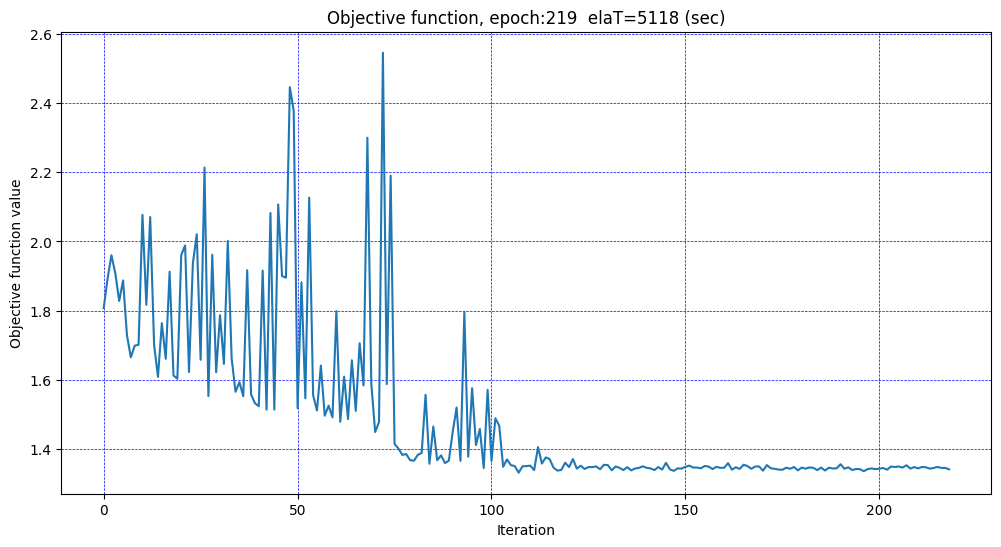

Training time: 5138 seconds, last value:1.34
0.6333333333333333


In [356]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
# fit classifier to data
model.fit(X_train, y_train)
elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds, last value:%.2f"%objective_func_vals[-1])

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
print(model.score(X_train, y_train))

#close your session
#session.close()

### predict for few samples

In [357]:
# Predict labels for the test data
y_pred =model.predict(X_test)
# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
#print(conf_matrix)
print('confusion matrix')
for i,rec  in enumerate(conf_matrix):
    print('true:%d  reco:%s'%(i,rec)

[[6 4 0]
 [3 2 4]
 [0 3 8]]


In [358]:
# Now we check out how well our classical model performs. 
# mean accuracy of the classifier
train_score_c4 = model.score(X_train, y_train)
test_score_c4 = model.score(X_test, y_test)

print(f"mean accuracy  on the training dataset: {train_score_c4:.2f}")
print(f"mean accuracy on the test dataset:     {test_score_c4:.2f}")

mean accuracy  on the training dataset: 0.59
mean accuracy on the test dataset:     0.60


In [359]:
# run full circuit for 
weights=model.weights
'weihts:',weights.shape, weights

('weihts:',
 (23,),
 array([ 0.09021945,  0.27621548,  0.57991717,  0.44794219,  0.60836717,
         1.73027452,  1.74217354,  0.80956797,  0.35122016,  0.23428813,
         0.30824132,  0.86218267,  1.09406666,  1.81690736,  0.845245  ,
         0.11948299,  0.61669301,  0.52193632,  1.55925604,  0.32413641,
         0.38383333,  0.47319896, -0.07161685]))

In [360]:
nSamp=20
samples=X_test[:nSamp]
labels=y_test[:nSamp]
pred=model.predict(samples)
nok=0
for p,t in zip(pred,labels):
    print(p,t,p==t)
    nok+=p==t
print('avr prob=%.2f'%(nok/nSamp))

2 1 False
0 0 True
1 2 False
2 1 False
2 1 False
0 0 True
2 1 False
2 2 True
2 1 False
1 1 True
2 2 True
1 0 False
0 0 True
1 0 False
0 0 True
2 1 False
2 2 True
1 1 True
0 1 False
2 2 True
avr prob=0.50


In [ ]:
session.close()

In [365]:
for i,rec  in enumerate(conf_matrix):
    print('true:%d  reco:%s'%(i,rec))

true:0  reco:[6 4 0]
true:1  reco:[3 2 4]
true:2  reco:[0 3 8]
